# Store Allen Cell Types Database data in Blue Brain Nexus

The goal of this notebook is to collect, map, ingest, find and download data from the Allen Cell Types Database using Blue Brain Nexus and Neuroshapes

<img src="../ingest-allen-celltypes-db-in-nexus/assets/nexus_workshop_data_pipeline.png" width="1200">

## Prerequisites

This notebook assumes that
- you have created a project within the AWS sandbox deployment of Blue Brain Nexus. If not, follow the Blue Brain Nexus [Quick Start tutorial](https://bluebrain.github.io/nexus-bbp-domains/docs/bluebrainnexustutorialkcni/getting-started/index.html)
- the Neuroshapes schemas are available in the neurosciencegraph/datamodels project of the AWS sandbox deployment of Blue Brain Nexus

## Overview

You'll work through the following steps:

1. Configure Blue Brain Nexus environment
2. Collect and explore Allen Cell Types Database electrophysiology and neuron morphology data (files and metadata)
3. Store electrophysiology and neuron morphology files in Blue Brain Nexus
4. Map Allen Cell Types Database metadata to Neuroshapes
5. Store mapped Allen Cell Types Database metadata in Blue Brain Nexus
6. Find and download stored data using SPARQL

## Step 0: Clone the tuorial Github project (Google Colab only)¶

In [ ]:
"""
import os 

tutorial_base_dir = "/content/nexus-bbp-domains"
if os.path.exists(tutorial_base_dir):
  !rm -R $tutorial_base_dir

!git clone --single-branch --branch docs https://github.com/BlueBrain/nexus-bbp-domains.git
os.chdir("/".join([tutorial_base_dir,"src/main/paradox/docs/bluebrainnexustutorialkcni/notebooks"]))

print("The working directory is now:")
!pwd
"""

## Step 1: Configure Blue Brain Neuxs environment

Install the required python packages

In [ ]:
# !pip install allensdk
# !pip install -U nexus-sdk
# !pip install rdflib
# !pip install SPARQLWrapper

Import the required python packages

In [1]:
import requests
import json
import getpass
import pandas as pd
import os
import matplotlib.pyplot as plt

from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
from allensdk.core.cell_types_cache import ReporterStatus as RS
from allensdk.core.swc import Marker

from sparqlendpointhelper import SparqlViewHelper
import nexussdk as nexus
import Nexus.Mapper as mapper
import Nexus.Utils as utils
import Nexus.Neuroshapes as neuroshapes

Set up the Blue Brain Nexus sandbox environment

In [2]:
DEPLOYMENT = "https://sandbox.bluebrainnexus.io/v1"

In [3]:
TOKEN = getpass.getpass() # Paste your token here

 ·······································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································

In [4]:
nexus.config.set_environment(DEPLOYMENT)

In [5]:
nexus.config.set_token(TOKEN)

In [6]:
ORGANIZATION = "tutorialnexus" # For the purpose of this workshop, we will be working in the tutorialnexus organization of the sandbox deployment

In [7]:
PROJECT = "akkaufma" # Paste your project label here

Configure your project in the tutorialnexus organization

In [8]:
utils.configure_project(nexus, DEPLOYMENT, ORGANIZATION, PROJECT)

## Step 2: Collect and explore Allen Cell Types Database electrophysiology and neuron morphology data (files and metadata)

We will be working with neuron morphology and electrophysiology data from the [Allen Cell Types Database](https://celltypes.brain-map.org/). The [AllenSDK](https://allensdk.readthedocs.io/en/latest/) can be used for data download

In [158]:
ctc = CellTypesCache(manifest_file="./allen_cell_types_db/manifest.json")

We will select all cells for which there is a reconstructed neuron morphology and electrophysiology data available

In [159]:
allen_cells = ctc.get_cells(require_reconstruction = True)

In [160]:
print("Total number of cells in the Allen Cell Types Database which have ephys and reconstruction data: %d" % len(allen_cells))

Total number of cells in the Allen Cell Types Database which have ephys and reconstruction data: 637


We will be downloading a subset of the data from the Allen Cell Types Database (the 20 first cells)

In [161]:
allen_cells_ids = [c["id"] for c in allen_cells][0:20]

Download the reconstructed neuron morphology files (file format: swc)

In [162]:
allen_cells_reconstruction = [ctc.get_reconstruction(i) for i in allen_cells_ids]

Download the trace collection files (file format: nwb)

In [163]:
allen__cells_electrophysiology = [ctc.get_ephys_data(i) for i in allen_cells_ids]

2019-11-20 22:55:18,072 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/491316386
2019-11-20 22:55:40,084 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/491200673
2019-11-20 22:56:02,913 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/491316017
2019-11-20 22:56:59,470 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/544847110
2019-11-20 22:57:30,887 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/618213231
2019-11-20 22:57:40,164 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/491198827
2019-11-20 22:59:44,870 allensdk.api.api.retrieve_fi

Acces the cells.json metadata file

In [8]:
allen_cells_metadata = utils.load_json("./allen_cell_types_db/cells.json")

Display the first element from the cells.json file

In [165]:
allen_cells_metadata[0]

{'cell_reporter_status': None,
 'csl__normalized_depth': None,
 'csl__x': 273.0,
 'csl__y': 354.0,
 'csl__z': 216.0,
 'donor__age': '25 yrs',
 'donor__disease_state': 'epilepsy',
 'donor__id': 524848408,
 'donor__name': 'H16.03.003',
 'donor__race': 'White or Caucasian',
 'donor__sex': 'Male',
 'donor__species': 'Homo Sapiens',
 'donor__years_of_seizure_history': '9',
 'ef__adaptation': 0.0278459596639436,
 'ef__avg_firing_rate': 13.5725111407696,
 'ef__avg_isi': 73.6783333333333,
 'ef__f_i_curve_slope': 0.1671875,
 'ef__fast_trough_v_long_square': -53.8750038146973,
 'ef__peak_t_ramp': 4.10410666666667,
 'ef__ri': 159.531131386757,
 'ef__tau': 21.1810256736186,
 'ef__threshold_i_long_square': 90.0,
 'ef__upstroke_downstroke_ratio_long_square': 2.89546090494073,
 'ef__vrest': -70.56103515625,
 'ephys_inst_thresh_thumb_path': '/api/v2/well_known_file_download/529903142',
 'ephys_thumb_path': '/api/v2/well_known_file_download/529903140',
 'erwkf__id': 618211597,
 'line_name': '',
 'm__bi

Plot a reconstructed neuron morphology from the Allen Cell Types database

In [166]:
def plot_allen_morphology(morphology):
    fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    # Make a line drawing of x-y and y-z views
    for n in morphology.compartment_list:
        for c in morphology.children_of(n):
            axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color='black')
            axes[1].plot([n['z'], c['z']], [n['y'], c['y']], color='black')

    axes[0].set_ylabel('y')
    axes[0].set_xlabel('x')
    axes[1].set_xlabel('z')
    plt.show()

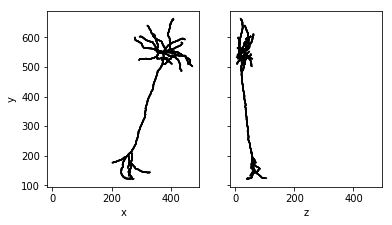

In [167]:
morphology = allen_cells_reconstruction[0]
plot_allen_morphology(morphology)

## Step 3: Store electrophysiology and neuron morphology files in Blue Brain Nexus

Store the neuron morphologies using the Blue Brain Nexus default storage

In [172]:
morph_files_metadata = dict()

In [173]:
for cell_id in allen_cells_ids:
    morph_files_metadata = utils.store_allen_files(nexus, cell_id=cell_id, data_type="reconstruction", 
                                                   metadata_dict=morph_files_metadata, org_label=ORGANIZATION, project_label=PROJECT)

485909730 reconstruction stored with @id https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/c9bf514d-c0eb-4e3c-a90e-0a37fd0dbbae
323865917 reconstruction stored with @id https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/5bc9ce0d-fee8-41fd-ab36-8f44b66f604c
476135066 reconstruction stored with @id https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/25dcbaf9-85e0-4fcf-b6d3-31450b3285f1
502614426 reconstruction stored with @id https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/2fb3746a-71d5-409f-a5d9-a986aa83ed97
519832676 reconstruction stored with @id https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/fe976484-40a7-41ee-918e-7e33e1aedd8a
480087928 reconstruction stored with @id https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/27dfca4a-b4a1-4c9b-92f5-c3bc800e13ef
596020931 reconstruction stored with @id https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexu

In [174]:
utils.save_json(morph_files_metadata, "./morph_files_metadata.json")

Store the electrophysiology using the Blue Brain Nexus default storage

In [175]:
ephys_files_metadata = dict()

In [177]:
for cell_id in allen_cells_ids[1:]:
    ephys_files_metadata = utils.store_allen_files(nexus, cell_id=cell_id, data_type="ephys", 
                                                   metadata_dict=ephys_files_metadata, org_label=ORGANIZATION, project_label=PROJECT)

323865917 ephys stored with @id https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/96569d8b-d111-4b42-93c6-dd3fcea5c2e2
476135066 ephys stored with @id https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/c4b15aa8-9054-47f1-8383-34e8a9f22452
502614426 ephys stored with @id https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/cd4b736a-56a8-4491-bb38-274dbba2fd4d
519832676 ephys stored with @id https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/e2e7b0ac-6300-46e2-af71-ed5070f2cde8
480087928 ephys stored with @id https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/5f60e755-6a78-49fc-b66a-ab77fa129b76
596020931 ephys stored with @id https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/82971e13-f0f5-4911-90c9-89cdddacc410
569095789 ephys stored with @id https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/2ee48c83-8fc2-4179-b4f9-6ac758a8f2cf
528706755 eph

In [178]:
utils.save_json(ephys_files_metadata, "./ephys_files_metadata.json")

Check out the stored files in [Nexus Web](https://sandbox.bluebrainnexus.io/web/tutorialnexus)

## Step 4: Map Allen Cell Types Database metadata to Neuroshapes

In [9]:
ephys_files_metadata = utils.load_json("ephys_files_metadata.json")

In [10]:
morphs_files_metadata = utils.load_json("morph_files_metadata.json")

Select the metadata of your subset of cells

In [11]:
subset_allen_cells_metadata = list()
for cell in allen_cells_metadata:
    if str(cell["specimen__id"]) in ephys_files_metadata.keys():
        subset_allen_cells_metadata.append(cell)

In [12]:
mapping = mapper.Mapper(deployment=DEPLOYMENT, org_label=ORGANIZATION, project_label=PROJECT)

Map the metadata provided by the Allen Cell Types Database to Neuroshapes

In [13]:
metadata_entities = mapping.allencelltypesdb2neuroshapes(PROJECT, subset_allen_cells_metadata)

In [14]:
metadata_entities[0]

{'@type': 'Subject',
 '@context': 'https://akkaufma.neuroshapes.org',
 '@id': 'https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/subject_485250100',
 'name': 'Cux2-CreERT2;Ai14-205530',
 'species': {'@id': 'https://www.ncbi.nlm.nih.gov/taxonomy/10090',
  'label': 'Mus musculus'},
 'identifier': 485250100,
 'strain': {'@id': 'https://www.mmrrc.org/catalog/sds.php?mmrrc_id=032779',
  'label': 'Cux2-CreERT2'}}

Add experimental protocol information to the metadata entities

In [15]:
experiment = neuroshapes.Experiment(PROJECT)

In [16]:
ephys_experimental_protocol = experiment.experimentalprotocol(name="Technical White Paper: Electrophysiology",
                                                            at_id="http://help.brain-map.org/download/attachments/8323525/CellTypes_Ephys_Overview.pdf?version=2&modificationDate=1508180425883&api=v2",
                                                            author_id="https://www.grid.ac/institutes/grid.417881.3",
                                                            author_type="Organization",
                                                            description="Protocol used to generate Allen Cell Types Database")

In [17]:
metadata_entities.append(ephys_experimental_protocol)

In [18]:
reconstruction_experimental_protocol = experiment.experimentalprotocol(name="Technical White Paper: Cell Morphology and Histology",
                                                            at_id="http://help.brain-map.org/download/attachments/8323525/CellTypes_Morph_Overview.pdf?version=4&modificationDate=1528310097913&api=v2",
                                                            author_id="https://www.grid.ac/institutes/grid.417881.3",
                                                            author_type="Organization",
                                                            description="Protocol used to generate Allen Cell Types Database")

In [19]:
metadata_entities.append(reconstruction_experimental_protocol)

In [20]:
utils.save_json(metadata_entities, "./metadata_entities.json")

## Step 5: Store mapped Allen Cell Types Database metadata in Blue Brain Nexus

Store the Neuroshapes entities in your project in Blue Brain Nexus

In [21]:
utils.store_allen_metadata(nexus, ORGANIZATION, PROJECT, metadata_entities, morphs_files_metadata, ephys_files_metadata)

{
  "@type": "Subject",
  "@context": "https://akkaufma.neuroshapes.org",
  "@id": "https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/subject_485250100",
  "name": "Cux2-CreERT2;Ai14-205530",
  "species": {
    "@id": "https://www.ncbi.nlm.nih.gov/taxonomy/10090",
    "label": "Mus musculus"
  },
  "identifier": 485250100,
  "strain": {
    "@id": "https://www.mmrrc.org/catalog/sds.php?mmrrc_id=032779",
    "label": "Cux2-CreERT2"
  }
}
409 Client Error: Conflict for url: https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/datashapes%3Asubject
---
{
  "@context": "https://bluebrain.github.io/nexus/contexts/error.json",
  "@type": "ResourceAlreadyExists",
  "reason": "Resource 'https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/subject_485250100' already exists."
}
{
  "@type": "SliceCollection",
  "@context": "https://akkaufma.neuroshapes.org",
  "@id": "https://sandbox.bluebrainnexus.io/v1/resources/tutorialnexus/akkaufma/_/

Check out the metadata in [Nexus Web](https://sandbox.bluebrainnexus.io/web/tutorialnexus)

## Step 6: Find and download stored data using SPARQL

Define the brain region layer and mouse strain to filter by

In [ ]:
data_type = "nsg:ReconstructedNeuronMorphology"
brain_region_layer = "\"layer 4\""
strain = "\"Rorb-IRES2-Cre\""

Run a SPARQL query and get the results as data frame

In [ ]:
sparqlview_endpoint = f"{DEPLOYMENT}/views/{ORGANIZATION}/{PROJECT}/graph/sparql"

In [ ]:
nexus_df = utils.query_data(sparqlview_endpoint, data_type, brain_region_layer, strain, TOKEN)

In [ ]:
if nexus_df is not None:
    entities = list(set(zip(nexus_df["id"], nexus_df["downloadUrl"], nexus_df["name"])))
    results_df = pd.DataFrame(data=list(entities), columns=nexus_df.columns)
else:
    results_df = None
    print("No result was found")

In [ ]:
results_df

Download the filtered reconstructed neuron morphologies

In [ ]:
data_dir ="./Download/"

In [ ]:
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [ ]:
download_urls = results_df["downloadUrl"]

In [ ]:
for url in download_urls:    
    try:
        response = nexus.files.fetch(ORGANIZATION, PROJECT, file_id=url, out_filepath=data_dir)
    except nexus.HTTPError as e:
        print(e)
        nexus.tools.pretty_print(resource)
        print("----")
        nexus.tools.pretty_print(e.response.json())

### END